# Equity Option Implied Volatility Analytics with Python

Python has become an increasingly important tool in the domain of quantitative and algorithmic trading and research. This extends from senior quantitative analysts pricing complex derivatives using numerical techniques all the way to the retail trader using closed form valuation methods and analysis techniques. This talk will focus on the uses of Python in discovering unobserved features of listed equity options known as implied volatility.

In this talk, we'll learn a bit about Black-Scholes model, option pricing formula the "greeks" and how to code it all in Python. I'll then demonstrate how to gather options data using Pandas and apply various transformations to obtain the theoretical value of the option and the associated greeks. We'll then extend the talk to discuss implied volatility and show how to use Numpy methods to compute implied volatility and model missing and bad values. Finally, we'll use the results to visualize the so-called volatility skew and term structure to help inform potential trading decisions.

# About me

I studied finance, economics and computer science during my undergraduate coursework in the US. In graduate school I studied quantitative finance and trading. I traded interest rate derivatives for a hedge fund in Chicago, worked for JPMorgan, BP and am now APAC CIO at a global agricultural trading firm.

Because CIO has nothing to do with technology, I code in my free time.

I'm online:

* [LinkedIn](https://sg.linkedin.com/in/jasonstrimpel)
* [Twitter](https://twitter.com/jasonstrimpel)
* [Github](https://github.com/jasonstrimpel)
* [Blog](http://www.bespokeoptions.com/blog)
* [Finance Tools](http://finance.jasonstrimpel.com)
* [Meetup](http://www.meetup.com/members/37553102/)

# Important jargon

Let's start with the parameters. Options priced with Black-Scholes have five input variables, four of which can be observed in the market and one of which is latent (unobservable, more on this later).

* __Underlying stock price ($S$)__. Price of the underlying stock upon which the option derives its value.

* __Strike price ($K$)__. The price at which the owner of the option can buy the underlying in the case of a call or sell the underlying in the case of a put.

* __Time to expiration ($t$)__. Time (as a fraction of a 365 day year) until the expiration of the option.

* __Risk free rate ($r$)__. So-called risk free rate (this is better described as the rate of interest you would earn in a riskless security over the holding period of the option)

* __Volatility ($vol$)__. Volatility (or more usually implied volatility) is a latent value not actually observed in the market.

Let's import our modules and declare these variables in Python for later use.

In [1]:
# magic function to plot inline
%matplotlib inline

# import numpy and pyplot
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import pandas
import pandas.io.data as pd
import time
import datetime as dt
from math import sqrt, pi

print 'Numpy %s\nMatplotlib %s\nScipy %s\nPandas %s' % \
    (np.__version__, mat.__version__, scipy.__version__, pandas.__version__)


# underlying stock price
S = 45.0

# series of underlying stock prices to demonstrate a payoff profile
S_ = np.arange(40.0, 50.0, 0.01)

# strike price
K = 45.0

# time to expiration (you'll see this as T-t in the equation)
t = 164.0/365.0

# risk free rate (there's nuance to this which we'll describe later)
r = 0.02

# volatility (latent variable which is the topic of this talk)
vol = 0.25

Numpy 1.10.1
Matplotlib 1.4.3
Scipy 0.16.0
Pandas 0.17.0


/usr/local/anaconda/lib/python2.7/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


# What are options?

Options are standardized derivatives contracts that convey the buyer the right (but not obligation) to buy the underlying security in the case of a call option or sell the underlying security in the case of a put option at a given price before a given date (for American style options) or on a given date (European style options).

There are many types of options of which only a few are available for retail traders. "Exotics" exist that are generally large dollar trades (millions of US$) and traded among investment banks. These are generally custom built by quants to help solve a customer's specific financial problem

We will focus on plain vanilla, european style, equity options so we can use the famous Black-Scholes pricing formula. More on Black-Scholes a bit later.

Most derivatives have a payoff at the end of the life of the contract (expiration). For a call option, the payoff can be expressed simply as:

> $$max(S-K, 0)$$

While the payoff for a put option can be expressed as:

> $$max(K-S, 0)$$

Where $S$ and $k$ are defined above. In this case, $K$ remains fixed during the life of a contract.

Across a range of potential $S$ values, we can form what is commonly known as the "payoff profile" for a call option at expiration.

The challenge for quants is to figure out what the price of the option is *before* expiration. This is where option pricing models like Black-Scholes come into play.

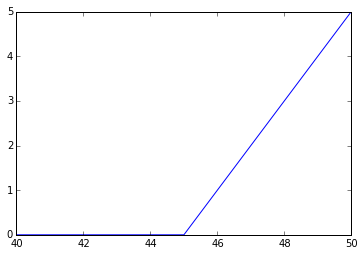

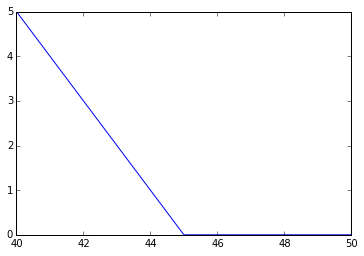

In [2]:
# use a lambda for a call payoff function
# equivelant to:
#
# def call_payoff(S, k):
#     return np.maximum(S - k, 0.0)
call_payoff = lambda S, K: np.maximum(S_ - K, 0.0)

# and put payoff function
put_payoff = lambda S, K: np.maximum(K - S_, 0.0)

# plot the call payoff 
plt.figure(1)
plt.plot(S_, call_payoff(S_, K))

# plot the put payoff
plt.figure(2)
plt.plot(S_, put_payoff(S_, K))

# What is the Black-Scholes option pricing model?

Black-Scholes is largely understood as an options pricing equation but it is really a framework that models a financial market. Within this framework the options pricing equation can be derived. The Black–Scholes model assumes that the market consists of at least one risky asset, usually called the stock, and one riskless asset, usually called the money market, cash, or bond.

Assumptions on the market:

* The rate of return on the riskless asset is constant and thus called the risk-free interest rate
* The instantaneous log returns of the stock price is an infinitesimal random walk with drift or geometric Brownian motion, and we will assume its drift and volatility is constant (if they are time-varying, we can deduce a suitably modified Black–Scholes formula quite simply, as long as the volatility is not random)
* The stock does not pay a dividend

Assumptions on the underlying security:

* There is no arbitrage opportunity (i.e. there is no way to make a riskless profit)
* It is possible to borrow and lend any amount, even fractional, of cash at the riskless rate
* It is possible to buy and sell any amount, even fractional, of the stock (this includes short selling)
* The above transactions do not incur any fees or costs (i.e. frictionless market).

As any trader knows, not a single one of these assumptions are actually true in reality. Probably the most imporant is the assumption of constant volatility which motivates this presentation.

Assume these assumptions do hold and suppose there is a derivative security also trading in this market. We specify that this security will have a certain payoff at a specified date in the future, depending on the value(s) taken by the stock up to that date. It is a surprising fact that the derivative's price is completely determined at the current time, even though we do not know what path the stock price will take in the future. (These are the payoffs we saw above.) For the special case of a European call or put option, Black and Scholes showed that *"it is possible to create a hedged position, consisting of a long position in the stock and a short position in the option, whose value will not depend on the price of the stock"*. Their dynamic hedging strategy led to a partial differential equation which governed the price of the option. Its solution is given by the Black–Scholes formula.

Source: https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model


# (Some of) the math

The famous Black-Scholes equation:

> $$\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^{2}S^{2}\frac{\partial^{2} V}{\partial S^{2}}+rS\frac{\partial V}{\partial S}-rV=0$$

The key financial insight behind the equation is that one can perfectly hedge the option by buying and selling the underlying asset in just the right way and consequently create an arbitrage free environment. This hedge, in turn, implies that there is only one right price for the option, as returned by the Black–Scholes formula. For this dynamic hedging to work, one must continuously hedge the movement in the underlying stock with the option which in reality, is prohibitive due to transaction costs.

I'll skip the derivation of the option price from the partial differential equation but the result solves for a call option

> $$C(S, t) = N(d_{1})S - N(d_{2})Ke^{-r(T-t)}$$

and put option

> $$P(S, t) = N(-d_{2})Ke^{-r(T-t)} - N(-d_{1})S$$

where

> $$d_{1} = \frac{ln(\frac{S}{K})+(r+\frac{\sigma^{2}}{2})(T-t)}{\sigma\sqrt{T-t}}$$

and

> $$d_{2} = d_{1} - \sigma\sqrt{T-t}$$

and finally

* $N(\cdot)$ is the cumulative distribution function of the standard normal distribution
* $T - t$ is the time to maturity (I use $t$ in the code)
* $S$ is the spot price of the underlying asset
* $K$ is the strike price
* $r$ is the risk free rate (annual rate, expressed in terms of continuous compounding)
* $\sigma$ is the volatility of returns of the underlying asset (I use $vol$ in the code)

# Black-Scholes equation in Python

Finally, enough math and some code. We'll be using Numpy so we vectorize the function which will help us later.

In [3]:
def N(z):
    """ Normal cumulative density function

    :param z: point at which cumulative density is calculated 
    :return: cumulative density under normal curve
    """
    return norm.cdf(z)


def black_scholes_call_value(S, K, r, t, vol):
    """ Black-Scholes call option

    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: BS call option value
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    
    return N(d1) * S - N(d2) * K * np.exp(-r * t)

def black_scholes_put_value(S, K, r, t, vol):
    """ Black-Scholes put option

    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: BS put option value
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    
    return N(-d2) * K * np.exp(-r * t) - N(-d1) * S


In [4]:
print 'Black-Scholes call value %0.2f' % black_scholes_call_value(S, K, r, t, vol)
print 'Black-Scholes put value %0.2f' % black_scholes_put_value(S, K, r, t, vol)

Black-Scholes call value 3.20
Black-Scholes put value 2.79


Because we vectorized the function, we can plot the Black-Scholes call value along a range of underlying stock prices. Going back to our example of the option value at expiration, let's see what it looks like with six, three and one month left to expiration.

In [5]:
black_scholes_call_values_six_months = black_scholes_call_value(S_, K, r, 0.5, vol)
black_scholes_call_values_three_months = black_scholes_call_value(S_, K, r, 0.25, vol)
black_scholes_call_values_one_month = black_scholes_call_value(S_, K, r, 1.0/12.0, vol)
call_payoff_at_expiration = call_payoff(S_, K)

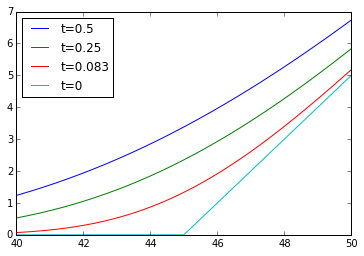

In [6]:
# plot the call payoff 
plt.figure(3)
plt.plot(S_, black_scholes_call_values_six_months)
plt.plot(S_, black_scholes_call_values_three_months)
plt.plot(S_, black_scholes_call_values_one_month)
plt.plot(S_, call_payoff_at_expiration)
plt.legend(['t=0.5', 't=0.25', 't=0.083', 't=0'], loc=2)

As you can see from the plot above, as the time to expiration decreases, the value of the option collapses towards the payoff value.

# The Greeks

A discussion about Black-Scholes would not be complete without a discussion of the Greeks. In mathematical terms, the Greeks are simply the partial derivatives of the option pricing formula. In other words, these are the sensitivities in the movement of the option price relative to the movement of other aspects of the input variables.

Because of the assumptions required for the Black-Scholes to hold true, the plain vanilla formula presented above is not usually used for pricing options. It is however, largely used for understanding the sensitivities of the option with respect to it's variables. The most common Greeks are as follows.

* **Delta**. Partial derivative of the option value with respect to the change in the underlying stock price. Delta measures how the underlying option moves with respect to moves in the underlying stock. The formula for delta is different for calls and puts.

> Call delta
> $$\frac{\partial V}{\partial S} = N(d_{1})$$

> Put delta
> $$\frac{\partial V}{\partial S} = N(d_{1})-1$$

* **Gamma**. Second partial derivative of the option value with respect to the change in the underlying stock price. Gamma measures movements in delta or the convexity in the value of the option with respect to the underlying.

> Gamma (same for call and put)
> $$\frac{\partial^2 V}{\partial S^2} = \frac{\phi(d_{1})}{S\sigma \sqrt{T-t}}$$

* **Vega**. Partial derivative of the option value with respect to the change in the volatility of the underling. Vega measures how the option price moves with respect to the volatility of the underlying. (Note vega is not a real greek letter.)

> Vega (same for call and put)
> $$\frac{\partial V}{\partial \sigma} = S\phi(d_{1}) \sqrt{T-t}$$

* **Theta**. Partial derivative of the option value with respect to the change in time. Theta measures how the value of the option decays as time passes. This was demonstrated in the plot above.

> Call theta
> $$\frac{\partial V}{\partial t} = -\frac{S\phi(d_{1})\sigma}{2\sqrt{T-t}} -rKe^{-r(T-t)}N(d_2)$$

> Put theta
> $$\frac{\partial V}{\partial t} = -\frac{S\phi(d_{1})\sigma}{2\sqrt{T-t}} +rKe^{-r(T-t)}N(-d_2)$$

* **Rho**. Partial derivative of the option value with respect to change in the risk-free interest rate. Rho measures how the option value changes as the interest rate changes.

> Call rho
> $$\frac{\partial V}{\partial r} = K(T-t)e^{-r(T-t)}N(d_2)$$

> Put rho
> $$\frac{\partial V}{\partial r} = -K(T-t)e^{-r(T-t)}N(-d_2)$$

Where $\phi$

> $$\phi(x) = \frac{e^{-\frac{x^2}{2}}}{\sqrt{2\pi}}$$

and $N(\cdot)$, $d_1$ and $d_2$ are defined above.

# The greeks in Python

Although we won't be discussing the greeks any further in this talk, let's code them up for completeness.

In [59]:
def phi(x):
    """ Phi helper function
    
    """
    return np.exp(-0.5 * x * x) / (sqrt(2.0 * pi))

def call_delta(S, K, r, t, vol):
    """ Black-Scholes call delta
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: call delta
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    
    return N(d1)

def put_delta(S, K, r, t, vol):
    """ Black-Scholes put delta
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: put delta
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    
    return N(d1) - 1.0

def gamma(S, K, r, t, vol):
    """ Black-Scholes gamma
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: gamma
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    
    return phi(d1) / (S * vol * sqrt(t))

def vega(S, K, r, t, vol):
    """ Black-Scholes vega
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: vega
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    
    return (S * phi(d1) * sqrt(t)) / 100.0

def call_theta(S, K, r, t, vol):
    """ Black-Scholes call theta
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: call theta
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    
    theta = -((S * phi(d1) * vol) / (2.0 * np.sqrt(t))) - (r * K * np.exp(-r * t) * N(d2))
    return theta / 365.0

def put_theta(S, K, r, t, vol):
    """ Black-Scholes put theta
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: put theta
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    
    theta = -((S * phi(d1) * vol) / (2.0 * np.sqrt(t))) + (r * K * np.exp(-r * t) * N(-d2))
    return theta / 365.0

def call_rho(S, K, r, t, vol):
    """ Black-Scholes call rho
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: call rho
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    
    rho = K * t * np.exp(-r * t) * N(d2)
    return rho / 100.0

def put_rho(S, K, r, t, vol):
    """ Black-Scholes put rho
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: put rho
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    
    rho = -K * t * np.exp(-r * t) * N(-d2)
    return rho / 100.0

In [60]:
print 'Black-Scholes call delta %0.4f' % call_delta(S, K, r, t, vol)
print 'Black-Scholes put delta %0.4f' % put_delta(S, K, r, t, vol)
print 'Black-Scholes gamma %0.4f' % gamma(S, K, r, t, vol)
print 'Black-Scholes vega %0.4f' % vega(S, K, r, t, vol)
print 'Black-Scholes call theta %0.4f' % call_theta(S, K, r, t, vol)
print 'Black-Scholes put theta %0.4f' % put_theta(S, K, r, t, vol)
print 'Black-Scholes call rho %0.4f' % call_rho(S, K, r, t, vol)
print 'Black-Scholes put rho %0.4f' % put_rho(S, K, r, t, vol)

Black-Scholes call delta 0.5546
Black-Scholes put delta -0.4454
Black-Scholes gamma 0.0524
Black-Scholes vega 0.1192
Black-Scholes call theta -0.0103
Black-Scholes put theta -0.0078
Black-Scholes call rho 0.0978
Black-Scholes put rho -0.1026


# Implied volatility

The Black-Scholes pricing model is usually used to solve for implied volatility. Quite simply, this means setting the Black-Scholes equation equal to a market observed price and using a root finding algorithm to solve for the volatility parameter which sets the difference (between model and market price) to zero.

The implied volatility is used for making trading decisions, calibrating other more exotic securities and researching market anomolies. For example, many traders use the so called volatility skew to understand the relative value of an option to other options trading in the market. We'll see examples of the skew later.

In the first of a two part [blog](http://www.bespokeoptions.com/blog/2015/10/06/implied-volatility-with-c-and-python-pt-1) series, I've discussed how to use C++ to find implied volatility. Here, we will use pure Python.

First we create an objective function which we'll pass to the Scipy implementation of the [Brentq algorithm](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.brentq.html). Then we'll create an implied volatilty function to return the volatility parameter that sets the observed market price to the model price.

In [93]:
def call_implied_volatility_objective_function(S, K, r, t, vol, call_option_market_price):
    """ Objective function for which sets market and model prices to zero
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :param call_option_market_price: market observed option price
    :return: error between market and model price
    """
    return call_option_market_price - black_scholes_call_value(S, K, r, t, vol)

def call_implied_volatility(S, K, r, t, call_option_market_price, a=-2.0, b=2.0, xtol=1e-6):
    """ Call implied volatility function
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param call_option_market_price: market observed option price
    :param a: lower bound for brentq method
    :param b: upper gound for brentq method
    :param xtol: tolerance which is considered good enough
    :return: volatility to sets the difference between market and model price to zero
    
    """
    
    # avoid mirroring out scope  
    _S, _K, _r, _t, _call_option_market_price = S, K, r, t, call_option_market_price
    
    # define a nsted function that takes our target param as the input
    def fcn(vol):
        
        # returns the difference between market and model price at given volatility
        return call_implied_volatility_objective_function(_S, _K, _r, _t, vol, _call_option_market_price)
    
    try:
        return brentq(fcn, a=a, b=b, xtol=xtol)
    except ValueError:
        return np.nan

def put_implied_volatility_objective_function(S, K, r, t, vol, put_option_market_price):
    """ Objective function for which sets market and model prices to zero
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :param call_option_market_price: market observed option price
    :return: error between market and model price
    """
    return put_option_market_price - black_scholes_put_value(S, K, r, t, vol)

def put_implied_volatility(S, K, r, t, put_option_market_price, a=-2.0, b=2.0, xtol=1e-6):
    """ Put implied volatility function
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param call_option_market_price: market observed option price
    :param a: lower bound for brentq method
    :param b: upper gound for brentq method
    :param xtol: tolerance which is considered good enough
    :return: volatility to sets the difference between market and model price to zero
    
    """
    
    # avoid mirroring out scope  
    _S, _K, _r, _t, _put_option_market_price = S, K, r, t, put_option_market_price
    
    # define a nsted function that takes our target param as the input
    def fcn(vol):
        
        # returns the difference between market and model price at given volatility
        return put_implied_volatility_objective_function(_S, _K, _r, _t, vol, _put_option_market_price)
    
    # capture the algorithm blowing up
    try:
        result = brentq(fcn, a=a, b=b, xtol=xtol)
        return np.nan if result <= 1.0e-6 else result
    except ValueError:
        return np.nan

In [94]:
call_model_price = black_scholes_call_value(S, K, r, t, vol)
print 'Call implied volatility if market and model were equal (should be close to 0.25) %0.6f' % call_implied_volatility(S, K, r, t, call_model_price)

put_model_price = black_scholes_put_value(S, K, r, t, vol)
print 'Put implied volatility if market and model were equal (should be close to 0.25) %0.6f' % put_implied_volatility(S, K, r, t, put_model_price)

Call implied volatility if market and model were equal (should be close to 0.25) 0.250000
Put implied volatility if market and model were equal (should be close to 0.25) 0.250000


# Getting real options market data

With the excellent [Pandas](http://pandas.pydata.org/) library (you are using Pandas, right?) we can grab entire options chains directly from Yahoo!. This is slow (it has to scrape several pages), but very useful. Chains include all options of all strikes for all expirations for a particular underlying stock.

The chains are returned in a very handy `MultiIndex pandas.DataFrame` object. Let's see how this works.

In [95]:
# define a stock symbol
underlying_symbol = 'IBM'

# define a Options object
options_obj = pd.Options('IBM', 'yahoo')

# request all chains for the underlying symbol
options_frame_live = options_obj.get_all_data()

# let's pickle the dataframe so we don't have to hit the network every time
options_frame_live.to_pickle('options_frame.pickle')

In [98]:
# read the original frame in from cache (pickle)
options_frame = pandas.read_pickle('options_frame.pickle')

In [99]:
# take a quick look at the DataFrame that returned
options_frame.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 541 entries, (70.0, 2016-07-15 00:00:00, put, IBM160715P00070000) to (290.0, 2016-01-15 00:00:00, put, IBM160115P00290000)
Data columns (total 13 columns):
Last                541 non-null float64
Bid                 541 non-null float64
Ask                 541 non-null float64
Chg                 541 non-null float64
PctChg              541 non-null object
Vol                 541 non-null int64
Open_Int            541 non-null int64
IV                  541 non-null object
Root                541 non-null object
IsNonstandard       541 non-null bool
Underlying          541 non-null object
Underlying_Price    541 non-null float64
Quote_Time          541 non-null datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(5), int64(2), object(4)
memory usage: 59.0+ KB


In [100]:
# and the first ten records
options_frame.head()

Last  Bid  Ask  Chg PctChg  Vol  \
Strike Expiry     Type Symbol                                                 
70     2016-07-15 put  IBM160715P00070000   0.22    0    0    0  0.00%   10   
       2017-01-20 put  IBM170120P00070000   0.60    0    0    0  0.00%   20   
       2018-01-19 call IBM180119C00070000  65.95    0    0    0  0.00%    4   
                  put  IBM180119P00070000   1.45    0    0    0  0.00%   57   
75     2016-07-15 put  IBM160715P00075000   0.40    0    0    0  0.00%    3   

                                           Open_Int      IV Root  \
Strike Expiry     Type Symbol                                      
70     2016-07-15 put  IBM160715P00070000        10  25.00%  IBM   
       2017-01-20 put  IBM170120P00070000       117  12.50%  IBM   
       2018-01-19 call IBM180119C00070000        19   0.00%  IBM   
                  put  IBM180119P00070000        88  12.50%  IBM   
75     2016-07-15 put  IBM160715P00075000         3  12.50%  IBM   

                                          IsNonstandard Underlying  \
Strike Expiry     Type Symbol                                        
70     2016-07-15 put  IBM160715P00070000         False        IBM   
       2017-01-20 put  IBM170120P00070000         False        IBM   
       2018-01-19 call IBM180119C00070000         False        IBM   
                  put  IBM180119P00070000         False        IBM   
75     2016-07-15 put  IBM160715P00075000         False        IBM   

                                           Underlying_Price  \
Strike Expiry     Type Symbol                                 
70     2016-07-15 put  IBM160715P00070000            135.85   
       2017-01-20 put  IBM170120P00070000            135.85   
       2018-01-19 call IBM180119C00070000            135.85   
                  put  IBM180119P00070000            135.85   
75     2016-07-15 put  IBM160715P00075000            135.85   

                                                   Quote_Time  
Strike Expiry     Type Symbol                                  
70     2016-07-15 put  IBM160715P00070000 2016-01-06 16:02:00  
       2017-01-20 put  IBM170120P00070000 2016-01-06 16:02:00  
       2018-01-19 call IBM180119C00070000 2016-01-06 16:02:00  
                  put  IBM180119P00070000 2016-01-06 16:02:00  
75     2016-07-15 put  IBM160715P00075000 2016-01-06 16:02:00

We're going to do some work to the `DataFrame` so that we can the Black-Scholes price and implied volatility to each of the options. So first let's do some clean up.

In [101]:
# reset the index so the strike and expiration become columns
options_frame.reset_index(inplace=True)

# remove PctChg and IV - we'll calculate our own
del options_frame['PctChg']
del options_frame['IV']

# rename the columns for consistency
columns = {'Expiry': 'Expiration',
           'Type': 'OptionType',
           'Symbol': 'OptionSymbol',
           'Vol': 'Volume',
           'Open_Int': 'OpenInterest',
           'Underlying_Price': 'UnderlyingPrice',
           'Quote_Time': 'QuoteDatetime',
           'Underlying': 'UnderlyingSymbol',
           'Chg': 'OptionChange'}

options_frame.rename(columns=columns, inplace=True)

Let's define some helper functions that we will apply to the `DataFrame`. These will provide some of the inputs to the option valuation functions.

In [102]:
def _get_days_until_expiration(series):
    """ Return the number of days until expiration

    :param series: row of the dataframe, accessible by label
    :return: days until expiration

    """
    expiration = series['Expiration']

    date_str = expiration.strftime('%Y-%m-%d') + ' 23:59:59'
    expiry = dt.datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")

    today = dt.datetime.today()
    # add one to count for today
    return (expiry - today).days + 1

def _get_time_fraction_until_expiration(series):
    """ Return the fraction of a year until expiration

    :param series: row of the dataframe, accessible by label
    :return: fraction of a year until expiration

    """

    expiration = series['Expiration']

    date_str = expiration.strftime('%Y-%m-%d') + ' 23:59:59'
    time_tuple = time.strptime(date_str, "%Y-%m-%d %H:%M:%S")

    expiry_in_seconds_from_epoch = time.mktime(time_tuple)
    right_now_in_seconds_from_epoch = time.time()

    seconds_until_expiration = expiry_in_seconds_from_epoch - right_now_in_seconds_from_epoch
    seconds_in_year = 31536000.0
    return max(seconds_until_expiration / seconds_in_year, 1e-10)

terms = [30, 3 * 30, 6 * 30, 12 * 30, 24 * 30, 36 * 30, 60 * 30]
rates = [0.0001, 0.0009, 0.0032, 0.0067, 0.0097, 0.0144, 0.0184]

def _get_rate(series):
    """ Interpolate rates out to 30 years
    
    :param series: row of the dataframe, accessable by label
    :return interpolated interest rate based on term structure

    """
    days = series['DaysUntilExpiration']
    
    new_terms = [i for i in range(30, (60 * 30) + 1)]
    f = interp1d(terms, rates, kind='linear')
    ff = f(new_terms)
    return round(ff[max(days, 30) - 30], 8)

def _get_mid(series):
    """ Get the mid price between bid and ask
    
    :param series: row of the dataframe, accessable by label
    :return mid price

    """
    bid = series['Bid']
    ask = series['Ask']
    last = series['Last']

    if np.isnan(ask) or np.isnan(bid):
        return 0.0
    elif ask == 0.0 or bid == 0.0:
        return last
    else:
        return (ask + bid) / 2.0

We can apply these functions to the `DataFrame` rowwise by setting the `axis` argument to `1` `apply` method.

In [103]:
options_frame['DaysUntilExpiration'] = options_frame.apply(_get_days_until_expiration, axis=1)
options_frame['TimeUntilExpiration'] = options_frame.apply(_get_time_fraction_until_expiration, axis=1)
options_frame['InterestRate'] = options_frame.apply(_get_rate, axis=1)
options_frame['Mid'] = options_frame.apply(_get_mid, axis=1)

Let's see what we've done.

In [104]:
options_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 540
Data columns (total 19 columns):
Strike                 541 non-null float64
Expiration             541 non-null datetime64[ns]
OptionType             541 non-null object
OptionSymbol           541 non-null object
Last                   541 non-null float64
Bid                    541 non-null float64
Ask                    541 non-null float64
OptionChange           541 non-null float64
Volume                 541 non-null int64
OpenInterest           541 non-null int64
Root                   541 non-null object
IsNonstandard          541 non-null bool
UnderlyingSymbol       541 non-null object
UnderlyingPrice        541 non-null float64
QuoteDatetime          541 non-null datetime64[ns]
DaysUntilExpiration    541 non-null int64
TimeUntilExpiration    541 non-null float64
InterestRate           541 non-null float64
Mid                    541 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(9), int64(3), 

In [105]:
options_frame.head()

,Strike,Expiration,OptionType,OptionSymbol,Last,Bid,Ask,OptionChange,Volume,OpenInterest,Root,IsNonstandard,UnderlyingSymbol,UnderlyingPrice,QuoteDatetime,DaysUntilExpiration,TimeUntilExpiration,InterestRate,Mid
0,70,2016-07-15,put,IBM160715P00070000,0.22,0,0,0,10,10,IBM,False,IBM,135.85,2016-01-06 16:02:00,192,0.523578,0.003433,0.22
1,70,2017-01-20,put,IBM170120P00070000,0.60,0,0,0,20,117,IBM,False,IBM,135.85,2016-01-06 16:02:00,381,1.041387,0.006875,0.60
2,70,2018-01-19,call,IBM180119C00070000,65.95,0,0,0,4,19,IBM,False,IBM,135.85,2016-01-06 16:02:00,745,2.038647,0.010026,65.95
3,70,2018-01-19,put,IBM180119P00070000,1.45,0,0,0,57,88,IBM,False,IBM,135.85,2016-01-06 16:02:00,745,2.038647,0.010026,1.45
4,75,2016-07-15,put,IBM160715P00075000,0.40,0,0,0,3,3,IBM,False,IBM,135.85,2016-01-06 16:02:00,192,0.523578,0.003433,0.40


# Applying implied volatility

We now have all the input parameters we need to follow the same procedure to add the Black-Scholes option value and the associated greeks. We'll begin as before by defining the functions we'll apply. Note that we have to compute the implied volatiltiy first. It is common practice to use the Black-Scholes equation to compute the implied volalatility then to use that result to compute the greeks.

We'll take the mid price (price between bid and ask) as this is generally considered the most representative price to use. As we'll see, there will be issues with the result which we'll have to clean.

In [106]:
def _get_implied_vol_mid(series):
    """

    """
    option_type = series['OptionType']
    S = series['UnderlyingPrice']
    K = series['Strike']
    r = series['InterestRate']
    t = series['TimeUntilExpiration']
    mid = series['Mid']
    
    # build method name
    meth_name = '{0}_implied_volatility'.format(option_type)
    
    # call from globals()
    return float(globals().get(meth_name)(S, K, r, t, mid))


In [107]:
# apply the function to the dataframe rowwise
options_frame['ImpliedVolatilityMid'] = options_frame.apply(_get_implied_vol_mid, axis=1)

In [108]:
# again, let's take a look
options_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 540
Data columns (total 20 columns):
Strike                  541 non-null float64
Expiration              541 non-null datetime64[ns]
OptionType              541 non-null object
OptionSymbol            541 non-null object
Last                    541 non-null float64
Bid                     541 non-null float64
Ask                     541 non-null float64
OptionChange            541 non-null float64
Volume                  541 non-null int64
OpenInterest            541 non-null int64
Root                    541 non-null object
IsNonstandard           541 non-null bool
UnderlyingSymbol        541 non-null object
UnderlyingPrice         541 non-null float64
QuoteDatetime           541 non-null datetime64[ns]
DaysUntilExpiration     541 non-null int64
TimeUntilExpiration     541 non-null float64
InterestRate            541 non-null float64
Mid                     541 non-null float64
ImpliedVolatilityMid    509 non-null fl

In [109]:
options_frame.head()

,Strike,Expiration,OptionType,OptionSymbol,Last,Bid,Ask,OptionChange,Volume,OpenInterest,Root,IsNonstandard,UnderlyingSymbol,UnderlyingPrice,QuoteDatetime,DaysUntilExpiration,TimeUntilExpiration,InterestRate,Mid,ImpliedVolatilityMid
0,70,2016-07-15,put,IBM160715P00070000,0.22,0,0,0,10,10,IBM,False,IBM,135.85,2016-01-06 16:02:00,192,0.523578,0.003433,0.22,4.446202e-01
1,70,2017-01-20,put,IBM170120P00070000,0.60,0,0,0,20,117,IBM,False,IBM,135.85,2016-01-06 16:02:00,381,1.041387,0.006875,0.60,3.760541e-01
2,70,2018-01-19,call,IBM180119C00070000,65.95,0,0,0,4,19,IBM,False,IBM,135.85,2016-01-06 16:02:00,745,2.038647,0.010026,65.95,6.301284e-07
3,70,2018-01-19,put,IBM180119P00070000,1.45,0,0,0,57,88,IBM,False,IBM,135.85,2016-01-06 16:02:00,745,2.038647,0.010026,1.45,3.294084e-01
4,75,2016-07-15,put,IBM160715P00075000,0.40,0,0,0,3,3,IBM,False,IBM,135.85,2016-01-06 16:02:00,192,0.523578,0.003433,0.40,4.442748e-01


# Interpolating missing and bad implied volatility values

In the `call_implied_volatility` and `put_implied_volatility` functions test for the Brentq solver blowing up. The solver will blow up if the option's mid price leads to a negative implied volatility. This happens with deep in or out of the money options where market makers keep the bid-ask spread wide.

Let's find the options where the implied volatility is `np.nan`.

In [110]:
bad_iv = options_frame[np.isnan(options_frame['ImpliedVolatilityMid'])]

In [111]:
bad_iv.count()

Strike                  32
Expiration              32
OptionType              32
OptionSymbol            32
Last                    32
Bid                     32
Ask                     32
OptionChange            32
Volume                  32
OpenInterest            32
Root                    32
IsNonstandard           32
UnderlyingSymbol        32
UnderlyingPrice         32
QuoteDatetime           32
DaysUntilExpiration     32
TimeUntilExpiration     32
InterestRate            32
Mid                     32
ImpliedVolatilityMid     0
dtype: int64

Now we'll interpolate the missing implied volatility values. There are *much* more sophisticated ways of doing this (see here) but we'll use simple linear interpolation to prove the technique.

First we'll define the function which we'll pass the frame to.

In [112]:
def _interp_implied_volatility(options_frame):
    """

    """
    frame = options_frame.set_index(['Expiration', 'OptionType', 'Strike']).sort_index()
    unstacked = frame['ImpliedVolatilityMid'].unstack(level=1).unstack(level=0)
    unstacked_interp = unstacked.interpolate().ffill().bfill()
    unstacked_interp_indexed = unstacked_interp.stack(level=0).stack(level=0).reset_index()
    frame['ImpliedVolatilityMid'] = unstacked_interp_indexed.set_index(['Expiration', 'OptionType', 'Strike'])
    frame.reset_index(inplace=True)
    return frame

In [113]:
options_frame = _interp_implied_volatility(options_frame)

In [114]:
bad_iv_post = options_frame[np.isnan(options_frame['ImpliedVolatilityMid'])]

In [115]:
bad_iv_post.count()

Expiration              0
OptionType              0
Strike                  0
OptionSymbol            0
Last                    0
Bid                     0
Ask                     0
OptionChange            0
Volume                  0
OpenInterest            0
Root                    0
IsNonstandard           0
UnderlyingSymbol        0
UnderlyingPrice         0
QuoteDatetime           0
DaysUntilExpiration     0
TimeUntilExpiration     0
InterestRate            0
Mid                     0
ImpliedVolatilityMid    0
dtype: int64

# Applying Black-Scholes and the greeks

Before we take a look at the implied volatility, let's apply the Black-Scholes formula and the associated greeks. First we define the functions we'll apply to the frame.

In [116]:
def _get_option_value(series):
    """

    """
    option_type = series['OptionType']
    S = series['UnderlyingPrice']
    K = series['Strike']
    r = series['InterestRate']
    t = series['TimeUntilExpiration']
    vol = series['ImpliedVolatilityMid']

    meth_name = 'black_scholes_{0}_value'.format(option_type)
    return float(globals().get(meth_name)(S, K, r, t, vol))

def _get_delta(series):
    """

    """
    option_type = series['OptionType']
    S = series['UnderlyingPrice']
    K = series['Strike']
    r = series['InterestRate']
    t = series['TimeUntilExpiration']
    vol = series['ImpliedVolatilityMid']

    meth_name = '{0}_delta'.format(option_type)
    return float(globals().get(meth_name)(S, K, r, t, vol))

def _get_gamma(series):
    """

    """
    S = series['UnderlyingPrice']
    K = series['Strike']
    r = series['InterestRate']
    t = series['TimeUntilExpiration']
    vol = series['ImpliedVolatilityMid']

    return float(gamma(S, K, r, t, vol))

def _get_vega(series):
    """

    """
    S = series['UnderlyingPrice']
    K = series['Strike']
    r = series['InterestRate']
    t = series['TimeUntilExpiration']
    vol = series['ImpliedVolatilityMid']

    return float(vega(S, K, r, t, vol))

def _get_theta(series):
    """

    """
    option_type = series['OptionType']
    S = series['UnderlyingPrice']
    K = series['Strike']
    r = series['InterestRate']
    t = series['TimeUntilExpiration']
    vol = series['ImpliedVolatilityMid']

    meth_name = '{0}_theta'.format(option_type)
    return float(globals().get(meth_name)(S, K, r, t, vol))

def _get_rho(series):
    """

    """
    option_type = series['OptionType']
    S = series['UnderlyingPrice']
    K = series['Strike']
    r = series['InterestRate']
    t = series['TimeUntilExpiration']
    vol = series['ImpliedVolatilityMid']

    meth_name = '{0}_rho'.format(option_type)
    return float(globals().get(meth_name)(S, K, r, t, vol))

def _get_model_error(series):
    """

    """
    option_last = series['Last']

    return option_last - _get_option_value(series)

In [117]:
options_frame['TheoreticalValue'] = options_frame.apply(_get_option_value, axis=1)
options_frame['Delta'] = options_frame.apply(_get_delta, axis=1)
options_frame['Gamma'] = options_frame.apply(_get_gamma, axis=1)
options_frame['Vega'] = options_frame.apply(_get_vega, axis=1)
options_frame['Theta'] = options_frame.apply(_get_theta, axis=1)
options_frame['Rho'] = options_frame.apply(_get_rho, axis=1)
options_frame['ModelError'] = options_frame.apply(_get_model_error, axis=1)

In [118]:
options_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 540
Data columns (total 27 columns):
Expiration              541 non-null datetime64[ns]
OptionType              541 non-null object
Strike                  541 non-null float64
OptionSymbol            541 non-null object
Last                    541 non-null float64
Bid                     541 non-null float64
Ask                     541 non-null float64
OptionChange            541 non-null float64
Volume                  541 non-null int64
OpenInterest            541 non-null int64
Root                    541 non-null object
IsNonstandard           541 non-null bool
UnderlyingSymbol        541 non-null object
UnderlyingPrice         541 non-null float64
QuoteDatetime           541 non-null datetime64[ns]
DaysUntilExpiration     541 non-null int64
TimeUntilExpiration     541 non-null float64
InterestRate            541 non-null float64
Mid                     541 non-null float64
ImpliedVolatilityMid    541 non-null fl

In [119]:
options_frame.head()

,Expiration,OptionType,Strike,OptionSymbol,Last,Bid,Ask,OptionChange,Volume,OpenInterest,...,InterestRate,Mid,ImpliedVolatilityMid,TheoreticalValue,Delta,Gamma,Vega,Theta,Rho,ModelError
0,2016-01-08,call,125,IBM160108C00125000,12.55,0,0,0,18,18,...,0.0001,12.55,1.394529e+00,12.550000,0.799194,0.019501,0.028960,-0.958807,0.005541,-3.738659e-09
1,2016-01-08,call,130,IBM160108C00130000,5.60,0,0,0,5,9,...,0.0001,5.60,6.214627e-07,5.850075,1.000000,0.000000,0.000000,-0.000036,0.007501,-2.500750e-01
2,2016-01-08,call,131,IBM160108C00131000,5.65,0,0,0,1,1,...,0.0001,5.65,6.222401e-01,5.650000,0.786047,0.045376,0.030067,-0.444184,0.005836,-8.622702e-08
3,2016-01-08,call,132,IBM160108C00132000,3.70,0,0,0,51,71,...,0.0001,3.70,1.436118e-06,3.850076,1.000000,0.000000,0.000000,-0.000036,0.007617,-1.500762e-01
4,2016-01-08,call,133,IBM160108C00133000,3.42,0,0,0,83,103,...,0.0001,3.42,3.950516e-01,3.420000,0.764717,0.075430,0.031733,-0.297640,0.005797,-1.475216e-08


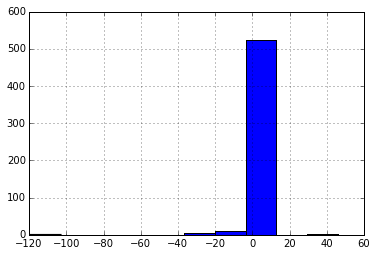

In [120]:
options_frame['ModelError'].hist()

In [122]:
iv = options_frame[options_frame['Expiration'] == '2016-01-08']

In [123]:
iv_call = iv[iv['OptionType'] == 'call']

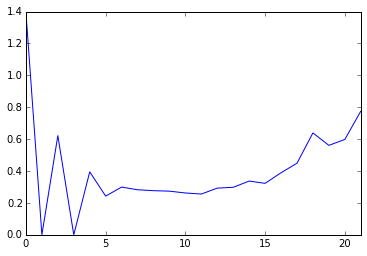

In [125]:
iv_call['ImpliedVolatilityMid'].plot()

# Unit tests
It's always important to test your code, especially in quant finance. Becuase the Black-Scholes is closed form and widely known, there are many pricing calculators online. My favorite is from [888options.com](http://www.888options.com)

# References

* http://daringfireball.net/projects/markdown/syntax
* https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model
* https://en.wikipedia.org/wiki/Greeks_(finance)
* http://www.888options.com
* http://www.codecogs.com/latex/eqneditor.php
* http://www.bespokeoptions.com/blog/2015/10/06/implied-volatility-with-c-and-python-pt-1
* http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.brentq.html